# Kenny Courser

# 1) Generate data that approximates real-world marketing and sales data.

In [3]:
import numpy as np
import pandas as pd

# Selecting a seed. Change this number and run all cells to try on different data.
np.random.seed(76)

# Defining initial parameters
weeks = 260                    # 5 years of weekly data
initial_subscribers = 100000   # 100k initial subs
total_weekly_budget = 15000    # 15k to spend on marketing each week split between tv, social media and (web) ads

# For the first week, since no previous data exists, we spend evenly (roughly) on tv, social media and (web) ads
tv_ratio = 0.334
social_ratio = 0.333
ads_ratio = 0.333

# Lists to store weekly data
tv_spend = []
social_media_spend = []
ads_spend = []
total_ad_spend = []
subscribers = [initial_subscribers]

# Function for diminishing returns on marketing costs
def diminishing_returns(spend, saturation_point=10000, max_effect=10000):
    return max_effect * (1 - np.exp(-spend / saturation_point))

# Generate weekly data
for i in range(weeks):
    # Randomly vary churn rate between 9% and 11%
    churn_rate = np.random.uniform(0.09, 0.11)
    
    if i == 0:
        # First week follows the predefined even split between marketing channels
        week_tv = total_weekly_budget * tv_ratio
        week_social = total_weekly_budget * social_ratio
        week_ads = total_weekly_budget * ads_ratio
    else:
        # If subscribers increased, maintain previous week's ratios
        if subscribers[-1] > subscribers[-2]:
            week_tv = total_weekly_budget * tv_ratio
            week_social = total_weekly_budget * social_ratio
            week_ads = total_weekly_budget * ads_ratio
        else:
            # Otherwise, randomly redistribute the budget while maintaining 15K total spent in marketing
            ratios = np.random.dirichlet([1, 1, 1])
            week_tv = total_weekly_budget * ratios[0]
            week_social = total_weekly_budget * ratios[1]
            week_ads = total_weekly_budget * ratios[2]
            tv_ratio, social_ratio, ads_ratio = ratios  # Update ratios

    # Store the amount spent in each marketing channel
    tv_spend.append(week_tv)
    social_media_spend.append(week_social)
    ads_spend.append(week_ads)
    total_ad_spend.append(total_weekly_budget)

    # Compute marketing effectiveness based on diminishing returns
    tv_effect = diminishing_returns(week_tv)
    social_effect = diminishing_returns(week_social)
    ads_effect = diminishing_returns(week_ads)

    # Seasonality component
    seasonality = 1 + 0.15 * np.sin(2 * np.pi * i / 52)

    # General chaos/noise term
    noise = np.random.normal(0, 2000)

    # Calculate new subscribers gained this week
    new_subs = max(0, (tv_effect + social_effect + ads_effect) * seasonality + noise)

    # Compute churn or subscriber loss for the week
    churned_subs = subscribers[-1] * churn_rate  # Now this varies each week

    # Update subscriber count
    subscribers.append(subscribers[-1] + new_subs - churned_subs)

# Create DataFrame
data = pd.DataFrame({
    "Week Number": np.arange(1, weeks + 1),
    "Number of Subscribers": subscribers[:-1],  # Exclude extra element
    "Amount Spent on TV": tv_spend,
    "Amount Spent on Social Media": social_media_spend,
    "Amount Spent on Ads": ads_spend,
    "Total Amount Spent in Advertising": total_ad_spend
})

# Save to CSV file because why not
data.to_csv("marketing_sales_data_updated.csv", index=False)

# Print the full dataset
pd.set_option("display.max_rows", None) # Show all rows
pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 200)        # Increase width to prevent wrapping

print(data)

     Week Number  Number of Subscribers  Amount Spent on TV  Amount Spent on Social Media  Amount Spent on Ads  Total Amount Spent in Advertising
0              1             100,000.00            5,010.00                      4,995.00             4,995.00                              15000
1              2             101,124.51            5,010.00                      4,995.00             4,995.00                              15000
2              3             105,691.16            5,010.00                      4,995.00             4,995.00                              15000
3              4             109,283.28            5,010.00                      4,995.00             4,995.00                              15000
4              5             112,321.62            5,010.00                      4,995.00             4,995.00                              15000
5              6             115,634.27            5,010.00                      4,995.00             4,995.00              

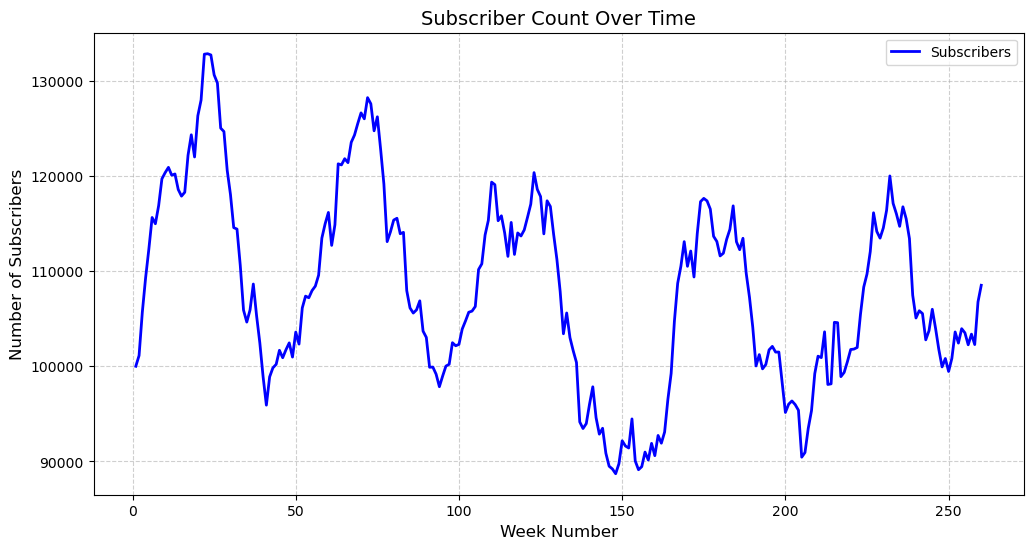

In [5]:
import matplotlib.pyplot as plt

# Load the updated dataset
df = pd.read_csv("marketing_sales_data_updated.csv")  # Ensure this matches your saved file

# Plot Number of Subscribers vs. Week Number
plt.figure(figsize=(12, 6))
plt.plot(df["Week Number"], df["Number of Subscribers"], label="Subscribers", color="blue", linewidth=2)

# Formatting
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Number of Subscribers", fontsize=12)
plt.title("Subscriber Count Over Time", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

# 2) Build a Bayesian MMM using the above generated data

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta_tv]
>Metropolis: [beta_social]
>Metropolis: [beta_ads]
>Metropolis: [sigma]


Output()

Sampling 2 chains for 250 tune and 2_000 draw iterations (500 + 4_000 draws total) took 341 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

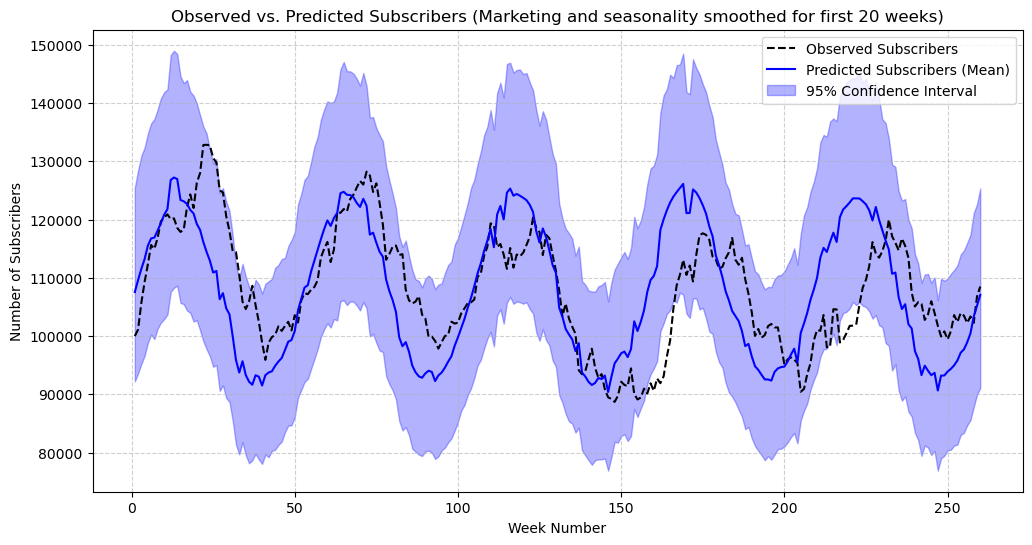

In [7]:
import pymc as pm
import arviz as az

# Load dataset
df = pd.read_csv("marketing_sales_data_updated.csv")

# Normalize amount spent on each marketing channel
df["tv_norm"] = df["Amount Spent on TV"] / df["Amount Spent on TV"].max()
df["social_media_norm"] = df["Amount Spent on Social Media"] / df["Amount Spent on Social Media"].max()
df["ads_norm"] = df["Amount Spent on Ads"] / df["Amount Spent on Ads"].max()

# Log-transform subscribers
df["log_subscribers"] = np.log(df["Number of Subscribers"])

# Smooth seasonality ramp-up (over first 26 Weeks) so model doesn't start out chaotically
seasonality_values = 0.15 * np.sin(2 * np.pi * np.arange(len(df)) / 52)
#seasonality_values[:26] = np.linspace(0, seasonality_values[26], 26)  # Gradual increase over 26 weeks

# Smooth marketing contribution start (over first 26 Weeks) so model doesn't start out chaotically
#df.loc[:25, "tv_norm"] *= np.linspace(0, 1, 26)  
#df.loc[:25, "social_media_norm"] *= np.linspace(0, 1, 26)
#df.loc[:25, "ads_norm"] *= np.linspace(0, 1, 26)

# Building our Bayesian MMM
with pm.Model() as bayesian_mmm:
    
    # Fix alpha at log(100,000) for 100k initial subscrubers
    alpha_fixed = np.log(100000)

    # Tighter priors for marketing effectiveness (half-normal for no negative subscribers from marketing, sigmas increases or decreases effects of
    # marketing on the model)
    beta_tv = pm.HalfNormal("beta_tv", sigma=0.05)  # Reduced influence
    beta_social = pm.HalfNormal("beta_social", sigma=0.05)
    beta_ads = pm.HalfNormal("beta_ads", sigma=0.05)

    # Seasonality
    seasonality = pm.Data("seasonality", seasonality_values)

    # Marketing contribution with diminishing returns
    def diminishing_returns(spend, beta, saturation=1):        # saturation=1 because we are modeling marketing effectiveness as a proportion
        return saturation * (1 - pm.math.exp(-beta * spend))

    # Expected Log subscribers
    mu = (
        alpha_fixed +  # Fixed baseline at log(100,000)
        diminishing_returns(df["tv_norm"], beta_tv) +
        diminishing_returns(df["social_media_norm"], beta_social) +
        diminishing_returns(df["ads_norm"], beta_ads) +
        seasonality
    )

    # Likelihood (log-normal subscribers) (smaller sigma=more accurate model but longer to build)
    sigma = pm.HalfNormal("sigma", sigma=0.01)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=df["log_subscribers"])

    # Run Monte-Carlo Markov chain sampling
    step = pm.Metropolis()                                           # comment this line out to use NUTS sampling instead of Metropolis sampling
    trace = pm.sample(2000, tune=250, step=step, chains=2, cores=2)  # 2k samples collected per chain, first 250 dropped, Metropolis sampler,
                                                                     # 2 independent chains on 2 CPU cores

    # Generate predictions for posterior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)
    trace.extend(posterior_predictive)  

    # Saving results
    az.to_netcdf(trace, "bayesian_mmm_trace.nc")

# Load posterior trace
trace = az.from_netcdf("bayesian_mmm_trace.nc")

# Extract posterior predictive samples
posterior_predictive = trace.posterior_predictive["y_obs"].values.reshape(-1, df.shape[0])

# Compute mean and 95% confidence intervals
mean_pred = np.mean(posterior_predictive, axis=0)
lower_bound = np.percentile(posterior_predictive, 2.5, axis=0)
upper_bound = np.percentile(posterior_predictive, 97.5, axis=0)

# Converting back from log-scale
observed_subscribers = df["Number of Subscribers"].values
predicted_mean = np.exp(mean_pred)
predicted_lower = np.exp(lower_bound)
predicted_upper = np.exp(upper_bound)

# Plot observed vs. predicted subscribers

plt.figure(figsize=(12, 6))
plt.plot(df["Week Number"], observed_subscribers, label="Observed Subscribers", color="black", linestyle="dashed")
plt.plot(df["Week Number"], predicted_mean, label="Predicted Subscribers (Mean)", color="blue")
plt.fill_between(df["Week Number"], predicted_lower, predicted_upper, color="blue", alpha=0.3, label="95% Confidence Interval")
plt.xlabel("Week Number")
plt.ylabel("Number of Subscribers")
plt.title("Observed vs. Predicted Subscribers (Marketing and seasonality smoothed for first 20 weeks)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Prior assumptions and modeling choies: 

## Forcing model to start at 100k initial subscribers, half-normal priors with $\sigma=0.05$ to ensure that marketing doesn't negatively affect subscribers as well as not influence the model too drastically, respectively. 

## Sine-like curve for seasonality-esque flavor and diminishing returns on market spend (ie subscribers do not increase linearly (or greater) with market spend).

## For model construction, used Metropolis sampling as NUTS was taking too long. Used a $\sigma$ value of $.01$ to reduce noise and force model to listen more closely to the observed data. Smaller $\sigma$'s give a more accurate model but the model will take longer to build.

# 3) Model insights

ROAS summary:
TV: Mean = 1.40, 95% confidence interval = 0.88 to 1.93
Social Media: Mean = 1.19, 95% confidence interval = 0.70 to 1.61
Ads: Mean = 0.49, 95% confidence interval = 0.09 to 0.94


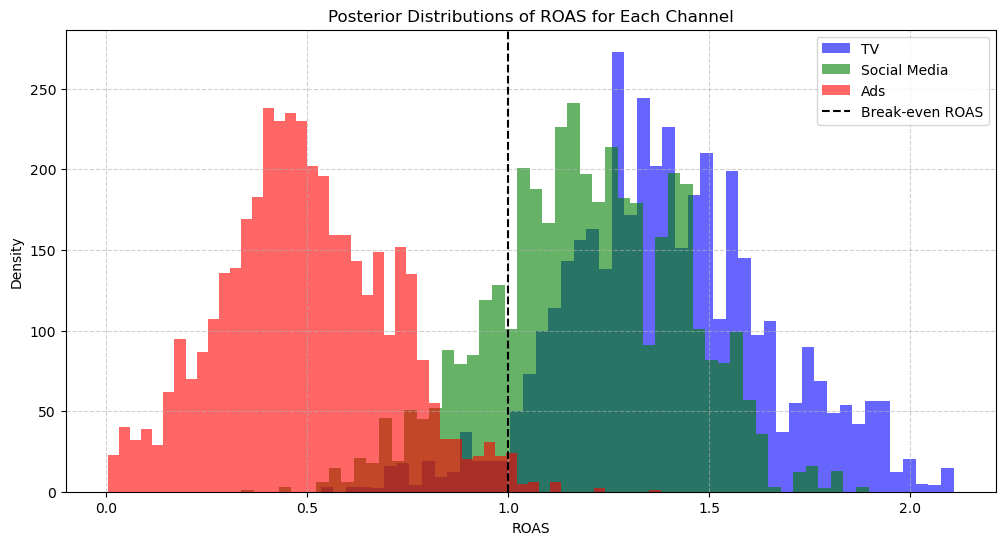

Recommended budget allocation for week 261:
TV: $6796.24 per week
Social Media: $5799.53 per week
Ads: $2404.23 per week


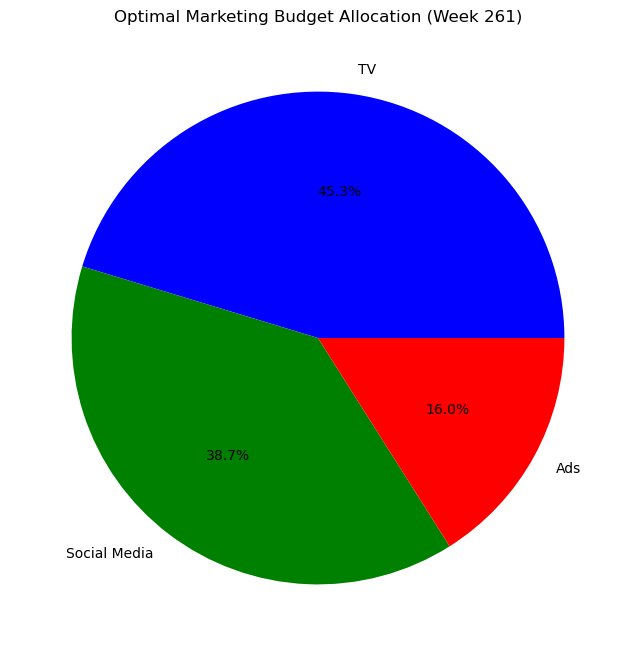

In [8]:
# Load posterior trace
trace = az.from_netcdf("bayesian_mmm_trace.nc")

# Extract posterior samples for marketing effectiveness (beta values)
beta_tv_samples = trace.posterior["beta_tv"].values.flatten()
beta_social_samples = trace.posterior["beta_social"].values.flatten()
beta_ads_samples = trace.posterior["beta_ads"].values.flatten()

# Compute return on ad spend for each marketing channel
roas_tv = beta_tv_samples * 15  # Each new subscriber generates $15/month
roas_social = beta_social_samples * 15
roas_ads = beta_ads_samples * 15

# Summarize ROAS distributions
roas_summary = {
    "TV": {"Mean": np.mean(roas_tv), "95% CI": np.percentile(roas_tv, [2.5, 97.5])},
    "Social Media": {"Mean": np.mean(roas_social), "95% CI": np.percentile(roas_social, [2.5, 97.5])},
    "Ads": {"Mean": np.mean(roas_ads), "95% CI": np.percentile(roas_ads, [2.5, 97.5])},
}

print("ROAS summary:")
for channel, stats in roas_summary.items():
    print(f"{channel}: Mean = {stats['Mean']:.2f}, 95% confidence interval = {stats['95% CI'][0]:.2f} to {stats['95% CI'][1]:.2f}")

# Visualizing ROAS distributions
plt.figure(figsize=(12, 6))
plt.hist(roas_tv, bins=50, alpha=0.6, label="TV", color="blue")
plt.hist(roas_social, bins=50, alpha=0.6, label="Social Media", color="green")
plt.hist(roas_ads, bins=50, alpha=0.6, label="Ads", color="red")
plt.axvline(x=1, color='black', linestyle="dashed", label="Break-even ROAS")
plt.xlabel("ROAS")
plt.ylabel("Density")
plt.title("Posterior Distributions of ROAS for Each Channel")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Determine channel effectiveness
roas_threshold = 1  # Break-even point (each $1 spent should return at least $1 in value)
high_performing = []
low_performing = []

# Optimized budget allocation based on ROAS
total_budget = 15000  # weekly ad budget

# Convert ROAS values into spending weights
mean_roas = np.array([np.mean(roas_tv), np.mean(roas_social), np.mean(roas_ads)])
spending_weights = mean_roas / np.sum(mean_roas)  # Normalize weights

# Allocate budget based on ROAS performance
optimal_budget = spending_weights * total_budget

# Display recommended budget allocation
budget_recommendations = {
    "TV": optimal_budget[0],
    "Social Media": optimal_budget[1],
    "Ads": optimal_budget[2]
}

print("Recommended budget allocation for week 261:")
for channel, budget in budget_recommendations.items():
    print(f"{channel}: ${budget:.2f} per week")

# Visualizing budget allocation in a pie chart
plt.figure(figsize=(8, 8))
plt.pie(optimal_budget, labels=["TV", "Social Media", "Ads"], autopct='%1.1f%%', colors=["blue", "green", "red"])
plt.title("Optimal Marketing Budget Allocation (Week 261)")
plt.show()

## Another assumption being made here with this budget allocation is that marketing channels are operating independently (ie, tv ads are not affecting social media engagement, which is likely not true in the real world).

# 4) Technical/Architectural considerations

## Data ingestion: Pull weekly marketing data from a database, api or csv file. Clean data (if necessary) and store in a new database or csv file. Automate using Airflow, AWS or Google Cloud and ETL pipelines in dbt or Prefect.

## Model training & updating: Can only train at most every new week data is observed, but training less frequently (eg monthly?) could be feasible. Can adjust priors if ROAS distributions experience significant change. Store previous models with MLflow in case something breaks. Can use AWS/Google cloud/Azure to automate weekly or monthly training, or can use cron jobs if scalability is not an issue.

## Model deployment: For fast, real-time insights, can use a REST API hosted on a cloud platform or a Docker container. For more detailed information, perhaps a weekly meeting/presentation, can store outputs in a database and utilize Looker/Tableau for visual presentations of ROAS and recommended budget allocations. Can store previous predictions in a SQL or BigQuery database for historical tracking.

## Infrastructure design: If lots of data, probably store on cloud platform. If small operation, Docker could work. Store raw data in SQL/BigQuery data base, processes data in a csv file or Parquet file if lots of data. Previous model versions stored in MLflow, GitHub actions for continuous integration of model and Docker+Kubernetes for containerized deployment.

## Monitoring: Can use Prometheus or DataDog to measure model performance and send a notification if performance drops below a specified threshold. Can implement various statistical tests to measure model drift, eg concept drift (one marketing channel strengthening or weakening over time), input data drift (eg the company beginning to favor one or multiple marketing channels when the model was trained with all marketing channels being balanced) or prediction drift (eg model starts over-predicting growth after an ad campaign when in reality growth is much smaller).

# 5) Improvements

## Allow for any $n \in \mathbb{N}$ marketing channels.

## Allow for dependence between marketing channels (eg, tv adds boost social media engagement).

## Different tiers of subscriptions (eg, 3 months for $ \$40 $, 6 months for $ \$75 $, a year for $ \$140 $, etc.).

## Can set better priors with more knowledge of the domain/situation with respect to how effective each marketing channel is.

## Model is only single-level: a hierarchical model could be made more accurate with more information/knowledge on regions that the marketing is targeting (ie, tv ads might do better in some countries than in others).

## Maybe account for outside economical factors? (eg how the economy is doing, certain stocks, trends, competition, recession, etc.)

## Account for time-varying effects, eg certain marketing channels being more effective at certain times of the year than others.

## General computational speed/model accuracy improvements. Metropolis sampling faster for small models, but NUTS sampling better for more complex models requiring more computational resources.